# Lead Classifier using pre-trained transformers

## Introduction

The goal is to classify leads using pre-trained transformers, This approach uses fine tuning the pretrained transformers for the task

### Importing the Libraries and Loading the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 labels: cold, warm, hot


d:\Agents\Lead_generator\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Agents\Lead_generator\my_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('../data/processed/cleaned_leads.csv', header = 0)

### Data Exploration

In [6]:
df.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,processed Name,job_title_feature_encoding,Industry_feature_encoding,combined_embeddings,lead_type,lead_label
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/,president,21st century healthcare inc,manufacturing,leanne wilhardt,[-5.30090868e-01 3.60419571e-01 -1.01226568e-...,[-4.47141767e-01 2.07234800e-01 -2.58643806e-...,tf.Tensor(\n[-0.53009087 0.36041957 -0.101226...,Cold,0
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/,chief executive officer,aa medical store,medical equipment manufacturing,ron plantz,[-5.16692519e-01 1.36982754e-01 -2.16177076e-...,[-2.99828410e-01 1.88840523e-01 -1.08319271e+...,tf.Tensor(\n[-0.5166925 0.13698275 -0.216177...,Cold,0
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/,president,ada med supply limited,retail,aniedi james,[-5.30090868e-01 3.60419571e-01 -1.01226568e-...,[-2.64491498e-01 2.03144141e-02 -2.37794787e-...,tf.Tensor(\n[-0.53009087 0.36041957 -0.101226...,Cold,0
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/,president,advanced instrumentations inc,biotechnology research,rafael celli,[-5.30090868e-01 3.60419571e-01 -1.01226568e-...,[ 2.55108718e-02 1.05550475e-01 -8.42230082e-...,tf.Tensor(\n[-0.53009087 0.36041957 -0.101226...,Cold,0
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/,president,aims inc,software development,robert canterbury,[-5.30090868e-01 3.60419571e-01 -1.01226568e-...,[-1.15125969e-01 1.68251693e-01 -6.21631384e-...,tf.Tensor(\n[-0.53009087 0.36041957 -0.101226...,Hot,2


In [7]:
df.columns

Index(['Name', 'Company', 'Website', 'Industry', 'Job Title', 'Email',
       'Linkedin URL', 'processed job_title', 'processed Company_name',
       'processed Industry_name', 'processed Name',
       'job_title_feature_encoding', 'Industry_feature_encoding',
       'combined_embeddings', 'lead_type', 'lead_label'],
      dtype='object')

In [8]:
df = df.drop(['processed Name', 'job_title_feature_encoding', 'Industry_feature_encoding', 'combined_embeddings'], axis = 1)

In [9]:
df.columns

Index(['Name', 'Company', 'Website', 'Industry', 'Job Title', 'Email',
       'Linkedin URL', 'processed job_title', 'processed Company_name',
       'processed Industry_name', 'lead_type', 'lead_label'],
      dtype='object')

In [10]:
df['text'] = df['processed job_title'].astype(str) + ' [SEP] ' + df['processed Industry_name'].astype(str)


In [11]:
df.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,lead_type,lead_label,text
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/,president,21st century healthcare inc,manufacturing,Cold,0,president [SEP] manufacturing
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/,chief executive officer,aa medical store,medical equipment manufacturing,Cold,0,chief executive officer [SEP] medical equipmen...
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/,president,ada med supply limited,retail,Cold,0,president [SEP] retail
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/,president,advanced instrumentations inc,biotechnology research,Cold,0,president [SEP] biotechnology research
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/,president,aims inc,software development,Hot,2,president [SEP] software development


### Vectorizing the Data

In [12]:
def tokenize_text(texts, tokenizer, max_length=128):
    tokens = tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    return tokens

In [13]:
tokens = tokenize_text(df['text'], tokenizer)

In [14]:
tokens

{'input_ids': <tf.Tensor: shape=(101, 11), dtype=int32, numpy=
array([[ 101, 2343,  102, ...,    0,    0,    0],
       [ 101, 2708, 3237, ...,  102,    0,    0],
       [ 101, 2343,  102, ...,    0,    0,    0],
       ...,
       [ 101, 2343,  102, ...,    0,    0,    0],
       [ 101, 2708, 3237, ...,  102,    0,    0],
       [ 101, 3580, 2343, ...,  102,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(101, 11), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(101, 11), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])>}

In [15]:
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
labels = df['lead_label'].values

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': input_ids,
    'attention_mask': attention_mask
}, labels))

### Splitting the Data for Training and Validation

In [17]:

# Define a function to split dataset
def split_dataset(dataset, split_ratio=0.1):
    # Shuffle dataset
    dataset = dataset.shuffle(buffer_size=1000)
    
    # Determine the number of examples
    num_examples = sum(1 for _ in dataset)
    num_train_examples = int(num_examples * (1 - split_ratio))
    
    # Split dataset
    train_dataset = dataset.take(num_train_examples)
    val_dataset = dataset.skip(num_train_examples)
    
    return train_dataset, val_dataset

# Example usage
train_dataset, val_dataset = split_dataset(dataset, split_ratio=0.2)


In [18]:
batch_size = 16
train_dataset = train_dataset.shuffle(100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

## Model Training and Evaluation

In [19]:
#fine tuning
from transformers import AdamWeightDecay, create_optimizer

# Define optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=1e-5, weight_decay_rate=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


In [20]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)

Epoch 1/10


5/5 [==============================] - 31s 2s/step - loss: 0.8407 - accuracy: 0.8250 - val_loss: 0.5400 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 0.6696 - accuracy: 0.8375 - val_loss: 0.6815 - val_accuracy: 0.7143
Epoch 3/10
5/5 [==============================] - 5s 970ms/step - loss: 0.5219 - accuracy: 0.8500 - val_loss: 0.5238 - val_accuracy: 0.7619
Epoch 4/10
5/5 [==============================] - 5s 944ms/step - loss: 0.4839 - accuracy: 0.8625 - val_loss: 0.4111 - val_accuracy: 0.9048
Epoch 5/10
5/5 [==============================] - 5s 958ms/step - loss: 0.3705 - accuracy: 0.9250 - val_loss: 0.4356 - val_accuracy: 0.9048
Epoch 6/10
5/5 [==============================] - 4s 892ms/step - loss: 0.3704 - accuracy: 0.9250 - val_loss: 0.1950 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.3528 - accuracy: 0.9250 - val_loss: 0.1981 - val_accuracy: 0.9524
Epoch 8/10
5/5 [==========

In [22]:
loss, accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


2/2 [==============================] - 0s 112ms/step - loss: 0.2573 - accuracy: 0.9524
Validation Loss: 0.2573363482952118
Validation Accuracy: 0.9523809552192688


In [24]:
model.save_pretrained('fine_tuned_bert')
tokenizer.save_pretrained('fine_tuned_bert')

('fine_tuned_bert\\tokenizer_config.json',
 'fine_tuned_bert\\special_tokens_map.json',
 'fine_tuned_bert\\vocab.txt',
 'fine_tuned_bert\\added_tokens.json')

In [25]:
model = TFBertForSequenceClassification.from_pretrained('fine_tuned_bert')
tokenizer = BertTokenizer.from_pretrained('fine_tuned_bert')

def predict_lead(job_title, industry):
    # Concatenate job title and industry
    text = f"{job_title} {industry}"
    
    # Tokenize the text
    tokens = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='tf')
    
    # Make prediction
    outputs = model(**tokens)
    logits = outputs.logits.numpy()
    
    # Get the predicted class
    predicted_class = np.argmax(logits, axis=1)[0]
    
    # Define label mapping
    labels = {0: 'cold', 1: 'warm', 2: 'hot'}
    
    return labels[predicted_class]

# Example usage
job_title = "Chief Executive Officer"
industry = "Medical Equipment Manufacturing"

prediction = predict_lead(job_title, industry)
print(f"Predicted lead classification: {prediction}")


Some layers from the model checkpoint at fine_tuned_bert were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at fine_tuned_bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predicted lead classification: cold


### Testing the model for prediction on known data and a customized input

In [26]:
import random
x = random.randint(0,100)
x

25

In [27]:
df[['processed job_title','processed Industry_name','lead_label','lead_type']].iloc[x]

processed job_title                chief executive officer
processed Industry_name    medical equipment manufacturing
lead_label                                               0
lead_type                                             Cold
Name: 25, dtype: object

In [28]:
job_title = df['processed job_title'][x]
job_title

'chief executive officer'

In [29]:
industry = df['processed Industry_name'][x]
industry

'medical equipment manufacturing'

In [30]:
prediction = predict_lead(job_title, industry)
print(f"Predicted lead classification: {prediction}")


Predicted lead classification: cold


In [31]:
prediction = predict_lead('chief executive officer', 'Software development')
print(f"Predicted lead classification: {prediction}")


Predicted lead classification: hot


### Plotting the Data

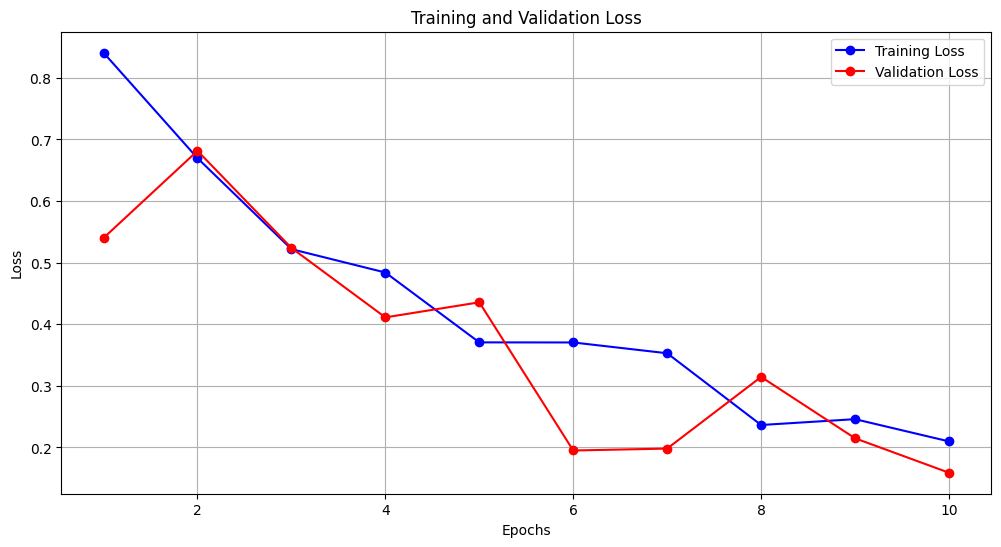

In [32]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


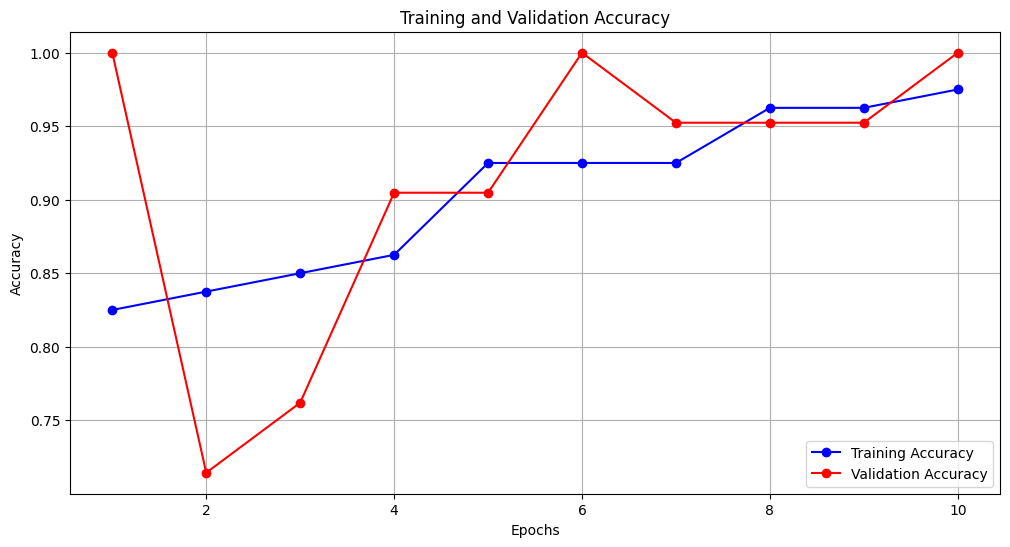

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


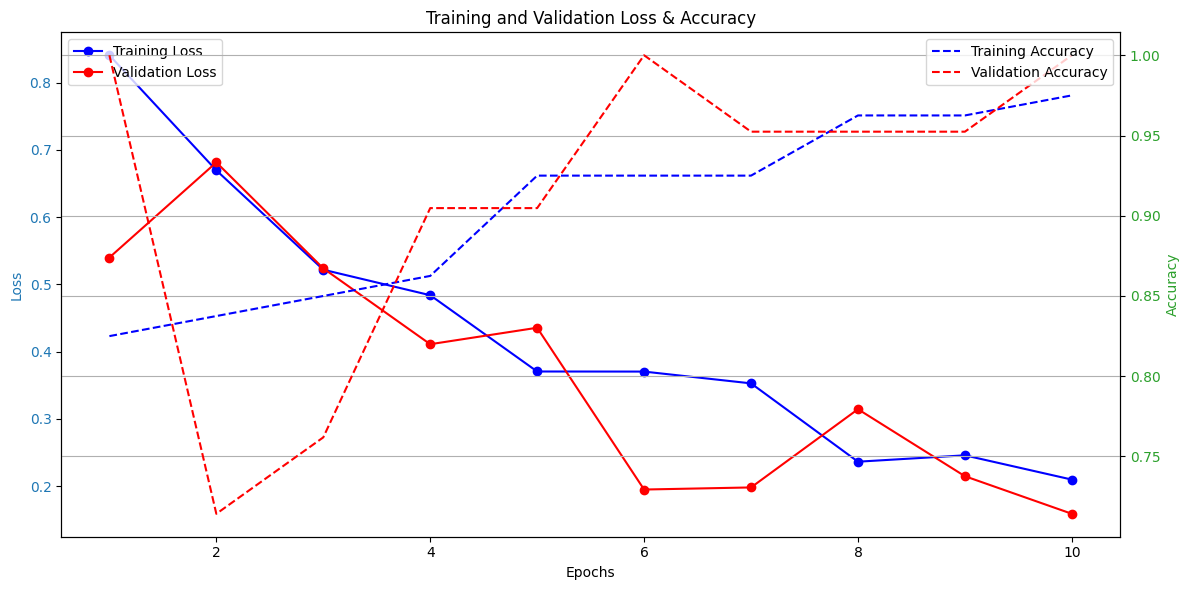

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot loss
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
ax1.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, history_dict['accuracy'], 'b--', label='Training Accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'r--', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Title and grid
plt.title('Training and Validation Loss & Accuracy')
fig.tight_layout()
plt.grid(True)
plt.show()


## Summary

Approach 2 involved fine tuning pre-trained transformer for entire classification process.
It yielded better results over the first approach.
Hyperparameter tuning helped in acheiving better model performance.

However, the caveat is that the dataset is very small and the a bigger dataset with inclusion of other parameters can yield in a model that has more scope and a better application for this classification task.

Considering the main idea behind this project was to get an understanding of applying transformer based approach for a classification task, the model working on the data set properly suffices.

Hyperparameter tuning, Quality of dataset used for the task, parameters considered, influence the performance of the model